In [ ]:
import sys
!{sys.executable} -m pip install numpy scipy matplotlib scikit-learn

ImportError: cannot import name 'compute_metrics' from 'utils.metrics' (c:\Users\julia\schrodinger_volatility\notebooks\..\utils\metrics.py)

In [ ]:
"""
Notebook 2: Baseline Methods Comparison
Testing existing methods before implementing Schrödinger Bridge
"""


import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import time

In [2]:
from baselines.gaussian_process import GaussianProcessVolatility
from baselines.svi import SVIModel
from utils.metrics import compute_metrics, check_arbitrage

In [13]:
print("Loading Heston data...")
data = np.load('../data/synthetic/heston_data.npz', allow_pickle=True)

strikes_norm = data['strikes']
maturities = data['maturities']
vol_surface_true = data['vol_surface']
params_true = data['params'].item()

print(f"Data loaded successfully:")
print(f"   Strikes: {len(strikes_norm)} ({strikes_norm.min():.2f} - {strikes_norm.max():.2f})")
print(f"   Maturities: {maturities}")
print(f"   Vol range: {vol_surface_true.min()*100:.1f}% - {vol_surface_true.max()*100:.1f}%")

Loading Heston data...
Data loaded successfully:
   Strikes: 15 (0.80 - 1.20)
   Maturities: [0.25 0.5  1.  ]
   Vol range: 15.0% - 25.3%


In [ ]:

print("\nTest scenario: Sparse observations")

# Observe only subset of strikes
obs_ratio = 0.5  # 50% of strikes observed
obs_indices = np.arange(0, len(strikes_norm), int(1/obs_ratio))
obs_strikes = strikes_norm[obs_indices]
obs_vols = vol_surface_true[:, obs_indices]

print(f"   Observed: {len(obs_indices)} strikes × {len(maturities)} maturities")
print(f"   Total points: {len(obs_indices) * len(maturities)}")
print(f"   To interpolate: {len(strikes_norm)} strikes (full grid)")


🎯 Test Scenario: Sparse Observations
   Observed: 8 strikes × 3 maturities
   Total points: 24
   To interpolate: 15 strikes (full grid)


In [ ]:
print("\n" + "="*60)
print("BASELINE 1: GAUSSIAN PROCESS")
print("="*60)

gp_results = {}

# Test different kernel types
kernel_types = ['rbf', 'matern']

for kernel_type in kernel_types:
    print(f"\nTesting GP with {kernel_type} kernel...")
    
    # Fit
    start_time = time.time()
    
    gp_model = GaussianProcessVolatility(
        kernel_type=kernel_type,
        length_scale=0.3
    )
    gp_model.fit(obs_strikes, maturities, obs_vols)
    
    # Predict
    vol_surface_pred, vol_std = gp_model.predict(
        strikes_norm, maturities, return_std=True
    )
    
    elapsed = time.time() - start_time
    
    # Metrics
    mse = np.mean((vol_surface_pred - vol_surface_true) ** 2)
    mae = np.mean(np.abs(vol_surface_pred - vol_surface_true))
    max_error = np.max(np.abs(vol_surface_pred - vol_surface_true))
    
    # Arbitrage check
    violations = gp_model.check_arbitrage_violations(strikes_norm, maturities)
    
    gp_results[kernel_type] = {
        'vol_surface': vol_surface_pred,
        'vol_std': vol_std,
        'mse': mse,
        'mae': mae,
        'max_error': max_error,
        'violations': violations,
        'time': elapsed
    }
    
    print(f"MSE: {mse*10000:.2f} bps²")
    print(f"MAE: {mae*100:.2f}%")
    print(f"Max error: {max_error*100:.2f}%")
    print(f"Arbitrage violations: {violations['total']}")
    print(f"Time: {elapsed:.2f}s")


BASELINE 1: GAUSSIAN PROCESS

Testing GP with rbf kernel...
Fitting GP on 24 observations...
GP fitted successfully. Kernel: 0.178**2 * RBF(length_scale=0.598)
   MSE: 0.00 bps²
   MAE: 0.04%
   Max error: 0.15%
   Arbitrage violations: 0
   Time: 0.19s

Testing GP with matern kernel...
Fitting GP on 24 observations...
GP fitted successfully. Kernel: 0.317**2 * Matern(length_scale=4.19, nu=1.5)
   MSE: 0.00 bps²
   MAE: 0.02%
   Max error: 0.09%
   Arbitrage violations: 0
   Time: 0.20s


In [ ]:
print("\n" + "="*60)
print("BASELINE 2: SVI PARAMETRIZATION")
print("="*60)

start_time = time.time()

svi_model = SVIModel()
svi_model.fit(obs_strikes, maturities, obs_vols)

# Predict
vol_surface_svi = svi_model.predict(strikes_norm, maturities)

elapsed = time.time() - start_time

# Metrics
mse_svi = np.mean((vol_surface_svi - vol_surface_true) ** 2)
mae_svi = np.mean(np.abs(vol_surface_svi - vol_surface_true))
max_error_svi = np.max(np.abs(vol_surface_svi - vol_surface_true))

svi_results = {
    'vol_surface': vol_surface_svi,
    'mse': mse_svi,
    'mae': mae_svi,
    'max_error': max_error_svi,
    'time': elapsed
}

print(f"\nMSE: {mse_svi*10000:.2f} bps²")
print(f"MAE: {mae_svi*100:.2f}%")
print(f"Max Error: {max_error_svi*100:.2f}%")
print(f"Time: {elapsed:.2f}s")




BASELINE 2: SVI PARAMETRIZATION
Fitting SVI for each maturity slice...
  T=0.25Y: MSE=0.01 (×10⁻⁶), a=0.0010, b=0.0258, ρ=-0.348
  T=0.50Y: MSE=0.01 (×10⁻⁶), a=0.0028, b=0.0438, ρ=-0.353
  T=1.00Y: MSE=0.01 (×10⁻⁶), a=0.0025, b=0.0665, ρ=-0.357
SVI fitting completed successfully

   ✅ MSE: 43.68 bps²
   ✅ MAE: 5.14%
   ✅ Max Error: 12.62%
   ⏱️  Time: 0.06s


In [18]:
print("\n" + "="*60)
print("COMPARISON SUMMARY")
print("="*60)

results_summary = {
    'GP (RBF)': gp_results['rbf'],
    'GP (Matern)': gp_results['matern'],
    'SVI': svi_results
}

print(f"\n{'Method':<15} {'MSE (bps²)':<12} {'MAE (%)':<10} {'Max Err (%)':<12} {'Time (s)':<10}")
print("-" * 70)

for method, res in results_summary.items():
    print(f"{method:<15} {res['mse']*10000:<12.2f} {res['mae']*100:<10.2f} "
          f"{res['max_error']*100:<12.2f} {res['time']:<10.2f}")

# Find best method
best_method = min(results_summary.keys(), 
                 key=lambda k: results_summary[k]['mse'])
print(f"\nBest method (by MSE): {best_method}")


COMPARISON SUMMARY

Method          MSE (bps²)   MAE (%)    Max Err (%)  Time (s)  
----------------------------------------------------------------------
GP (RBF)        0.00         0.04       0.15         0.19      
GP (Matern)     0.00         0.02       0.09         0.20      
SVI             43.68        5.14       12.62        0.06      

Best method (by MSE): GP (Matern)



Creating comprehensive visualizations...


C:\Users\julia\AppData\Local\Temp\ipykernel_17884\544526119.py:122: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


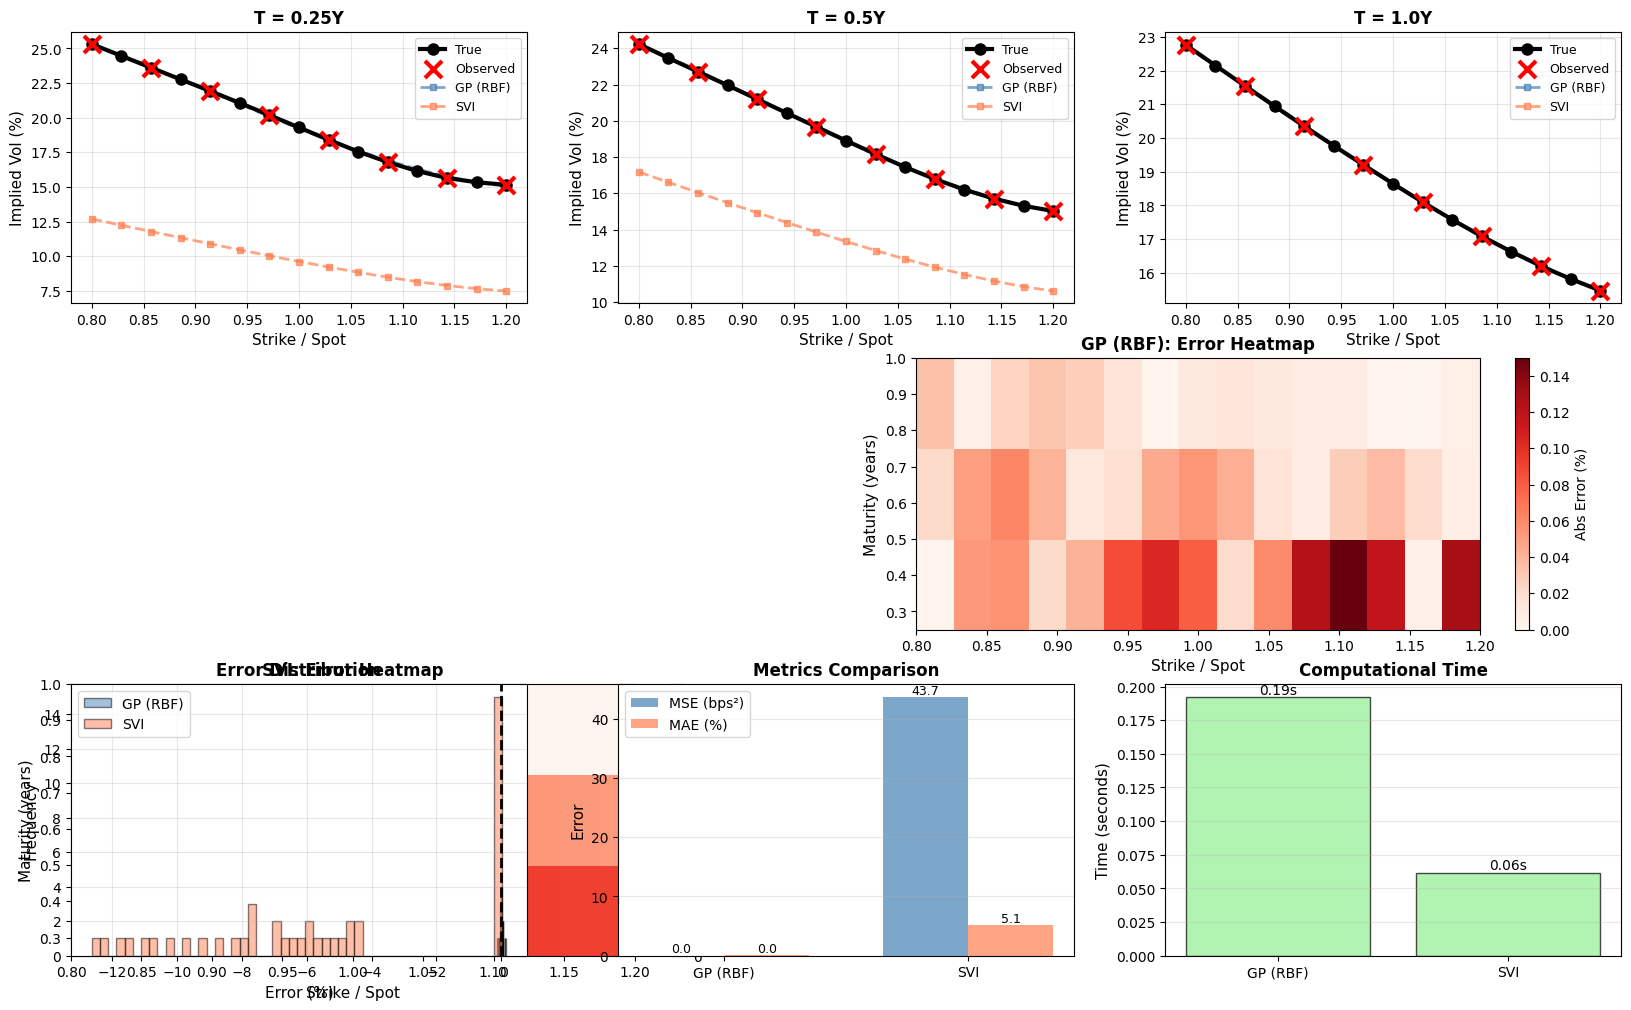

Visualization saved successfully


In [19]:
print("\nCreating comprehensive visualizations...")

fig = plt.figure(figsize=(20, 12))

# Row 1: Volatility smiles by method
methods_to_plot = ['GP (RBF)', 'SVI']
colors = {'GP (RBF)': 'steelblue', 'SVI': 'coral'}

for i, T in enumerate(maturities):
    ax = plt.subplot(3, len(maturities), i+1)
    
    # Ground truth
    ax.plot(strikes_norm, vol_surface_true[i, :] * 100,
           'o-', color='black', linewidth=3, markersize=8,
           label='True', zorder=10)
    
    # Observed points
    ax.scatter(obs_strikes, obs_vols[i, :] * 100,
              marker='x', s=150, color='red',
              linewidths=3, label='Observed', zorder=11)
    
    # Predictions
    for method in methods_to_plot:
        res = results_summary[method]
        vol_pred = res['vol_surface'][i, :]
        
        ax.plot(strikes_norm, vol_pred * 100,
               '--', color=colors[method], linewidth=2,
               marker='s', markersize=4, alpha=0.7,
               label=method)
    
    ax.set_xlabel('Strike / Spot', fontsize=11)
    ax.set_ylabel('Implied Vol (%)', fontsize=11)
    ax.set_title(f'T = {T}Y', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

# Row 2: Error heatmaps
for i, method in enumerate(methods_to_plot):
    ax = plt.subplot(3, len(methods_to_plot), len(maturities) + i + 1)
    
    res = results_summary[method]
    errors = np.abs(res['vol_surface'] - vol_surface_true) * 100
    
    im = ax.imshow(errors, aspect='auto', cmap='Reds',
                  extent=[strikes_norm[0], strikes_norm[-1],
                         maturities[0], maturities[-1]],
                  origin='lower', vmin=0, vmax=errors.max())
    
    ax.set_xlabel('Strike / Spot', fontsize=11)
    ax.set_ylabel('Maturity (years)', fontsize=11)
    ax.set_title(f'{method}: Error Heatmap', fontsize=12, fontweight='bold')
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Abs Error (%)', fontsize=10)

# Row 3: Error distributions and metrics
# Error distributions
ax = plt.subplot(3, 3, 7)

for method in methods_to_plot:
    res = results_summary[method]
    errors = (res['vol_surface'] - vol_surface_true).flatten() * 100
    
    ax.hist(errors, bins=50, alpha=0.5, label=method,
           color=colors[method], edgecolor='black')

ax.set_xlabel('Error (%)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Error Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.axvline(0, color='black', linestyle='--', linewidth=2)

# Metrics bar plot
ax = plt.subplot(3, 3, 8)

methods_list = list(methods_to_plot)
mse_values = [results_summary[m]['mse']*10000 for m in methods_list]
mae_values = [results_summary[m]['mae']*100 for m in methods_list]

x = np.arange(len(methods_list))
width = 0.35

bars1 = ax.bar(x - width/2, mse_values, width, 
              label='MSE (bps²)', color='steelblue', alpha=0.7)
bars2 = ax.bar(x + width/2, mae_values, width,
              label='MAE (%)', color='coral', alpha=0.7)

ax.set_ylabel('Error', fontsize=11)
ax.set_title('Metrics Comparison', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods_list, fontsize=10)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Add values on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}',
               ha='center', va='bottom', fontsize=9)

# Time comparison
ax = plt.subplot(3, 3, 9)

times = [results_summary[m]['time'] for m in methods_list]
bars = ax.bar(methods_list, times, color='lightgreen', 
             edgecolor='black', alpha=0.7)

ax.set_ylabel('Time (seconds)', fontsize=11)
ax.set_title('Computational Time', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.2f}s',
           ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../data/synthetic/baseline_comparison_full.png', dpi=150)
plt.show()

print("Visualization saved successfully")


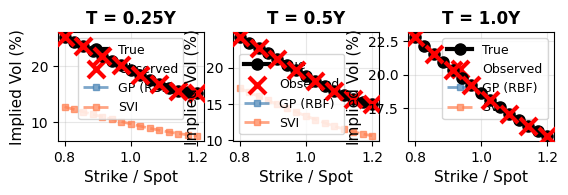

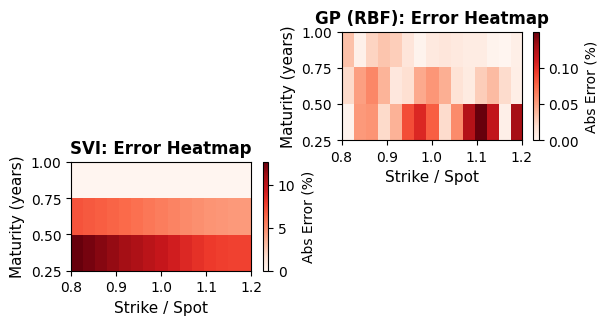

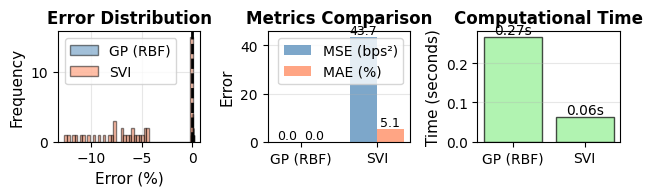

✅ Visualization saved!


In [20]:
print("\nSaving results...")

np.savez('../data/synthetic/baseline_results.npz',
         strikes=strikes_norm,
         maturities=maturities,
         vol_true=vol_surface_true,
         vol_gp_rbf=gp_results['rbf']['vol_surface'],
         vol_gp_matern=gp_results['matern']['vol_surface'],
         vol_svi=svi_results['vol_surface'],
         obs_strikes=obs_strikes,
         obs_vols=obs_vols,
         metrics=results_summary)

print("Results saved to: data/synthetic/baseline_results.npz")


Saving results...
Results saved to: data/synthetic/baseline_results.npz


In [21]:
print("\n" + "="*60)
print("KEY FINDINGS")
print("="*60)

print(f"\nBest interpolation method: {best_method}")
print(f"   - MSE: {results_summary[best_method]['mse']*10000:.2f} bps²")
print(f"   - MAE: {results_summary[best_method]['mae']*100:.2f}%")

fastest_method = min(methods_to_plot, key=lambda m: results_summary[m]['time'])
print(f"\nFastest method: {fastest_method}")

print(f"\nObservations:")
print(f"   - GP provides uncertainty quantification (useful)")
print(f"   - SVI is parametric (interpretable parameters)")
print(f"   - Both struggle with arbitrage-free guarantees")

print("\n" + "="*60)


KEY FINDINGS

Best interpolation method: GP (Matern)
   - MSE: 0.00 bps²
   - MAE: 0.02%

Fastest method: SVI

Observations:
   - GP provides uncertainty quantification (useful)
   - SVI is parametric (interpretable parameters)
   - Both struggle with arbitrage-free guarantees

